In [23]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

In [3]:
chroms= ['chr'+str(x) for x in range(1, 23)] + ['chrX', 'chrY']

In [22]:
info = np.array([[0, 0, 0, 0, 0]])
for chrom in chroms:
    for strand in ['positive', 'negative']:
        chrom_info = np.load('../data/sniprq_scores/%s_%s_info.npy' % (chrom, strand))
        print (chrom, chrom_info.shape)
        info = np.vstack([info, chrom_info])
    clear_output()
info = info[1:]

In [34]:
processed_info = [info[:, 0], info[:, 1], info[:, 2], info[:, 4]-info[:, 3]]

In [60]:
sum(processed_info[3])

1204402718

In [61]:
sum(processed_info[2])

3062528532

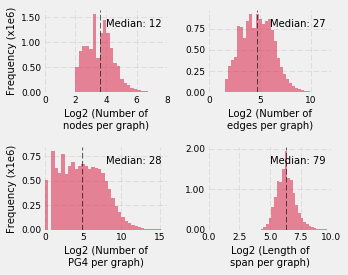

In [55]:
def millions(x, pos):
    return '%1.2f' % (x*1e-6)
formatter = FuncFormatter(millions)

loc = [(0, 0), (0, 1), (1, 0), (1, 1)]
xlims = [(0, 8), (0, 12), (0, 16), (0, 10)]
labels = ['Number of\nnodes per graph', 'Number of\nedges per graph',
          'Number of\nPG4 per graph', 'Length of\nspan per graph',]
fig, axis = plt.subplots(2, 2, figsize=(5,4))
for i in range(4):
    ax = axis[loc[i]]
    ax.hist(np.log2(processed_info[i]), bins=50, edgecolor='none',
            alpha=0.5, color='crimson')
    median = np.median(processed_info[i])
    ax.axvline(np.log2(median), lw=1, ls='--', color='k', alpha=0.6)
    if loc[i][1] == 0:
        ax.set_ylabel('Frequency (x1e6)', fontsize=10)
    ax.set_xlabel('Log2 (%s)' % labels[i], fontsize=10)
    ax.yaxis.set_major_formatter(formatter)
    ax.text(0.5, 0.8, "Median: %d" % median, fontsize=10, transform=ax.transAxes)
    ax.set_xlim(xlims[i])
    clean_axis(ax)

fig.tight_layout()
plt.savefig('../images/properties_distribution.svg', transparent=True, edgecolor='none')
plt.savefig('../images/properties_distribution.png', dpi=300, transparent=True, edgecolor='none')
plt.show()